#Imports/Permissions to load data

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#stuff we need
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.utils import get_custom_objects
from google.colab import drive
import h5py
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Dropout, BatchNormalization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pickle


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

drive.mount('/content/drive')

Mounted at /content/drive


#Data Scaling

In [2]:
x_val, y_val=np.empty([0, 110006]), np.empty([0, 6])
filepath='./drive/Shareddrives/ML_project/Complete_Spectral_Data/Training_Data/finished_data0'

allfiles, testfiles=np.arange(100), np.arange(0, 100, 10)
trainmask=[False if num in testfiles else True for num in allfiles]
trainfiles=shuffle(allfiles[trainmask], random_state=2)
pickle.dump(trainfiles, open('fileorder', 'wb'))

sc_x, sc_y=StandardScaler(), StandardScaler()

#This loading function is annoying and perhaps overly complicated, but basically, when preparing the data we accidentally left it in order of 
#stellar circularity fraction. So now we load 10 random files at a time, combine their entries, and randomly select part of our validation data 
#from this.
for i in range(0, 90, 10):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+10]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, np.log10(y)))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  y_chunk=np.where(y_chunk==np.log10(0), -1, y_chunk)
  print(max(y_chunk[:, -2]))
  #where ever y_chunk=-inf, we replace it with -1
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=0)  #train_test_split also shuffles data
  x_val, y_val=np.concatenate((x_val, xv)), np.concatenate((y_val, yv))
  sc_x.partial_fit(x_train)
  sc_y.partial_fit(y_train)
pickle.dump(x_val, open('log_x_validation_set', 'wb'))
pickle.dump(y_val, open('log_y_validation_set', 'wb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.74347089092314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.73053644037336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.351729796214638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.77432766540193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.532395703752098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.35880567440417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.547567500247034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.423258482623268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


16.456224373726034


In [3]:
y_chunk_new=np.where(y_chunk==np.log10(0), -1, y_chunk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [4]:
np.min(y_chunk_new[:, 1])

7.9521558384441535

#Train/Load Autoencoder

We train our auto-encoder and final model using mini-batches. After each minibatch, we save the autoencoder. This allows us to resume training manually after disconnects. When we finally train our model we simply load the autoencoder. 

In [5]:
#LeakyReLU definition and autoencoder initialization
def leaky_relu(z,name=None):
  return tf.maximum(0.01*z, z, name=name)
get_custom_objects().update({'leaky_relu':leaky_relu})

stacked_encoder, stacked_decoder = Sequential(), Sequential()
stacked_encoder.add(Dense(250,input_dim=len(x_train[0]), activation='leaky_relu'))  #from input dimensions to 250 neurons--> leaky

stacked_encoder.add(BatchNormalization())
stacked_encoder.add(Dense(40, activation='linear'))  #from 250 neurons to 40--> linear
stacked_decoder.add(BatchNormalization())

stacked_decoder.add(Dense(250,activation='linear',input_shape=[40]))   #from 40 neurons to 250--> linear
stacked_decoder.add(Dense(len(x_train[0]),activation='leaky_relu'))    #from 250 neurons to input dimensions--> leaky
stacked_ae = Sequential([stacked_encoder,stacked_decoder])
stacked_ae.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum = 0.95))

In [6]:
#Autoencoder training
#stacked_ae=keras.models.load_model('log_autoencoder.h5')
#stacked_encoder=keras.models.load_model('log_encoder.h5')
trainfiles=pickle.load(open('fileorder', 'rb'))
for i in range(70, 90, 10):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+10]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, np.log10(y)))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  y_chunk=np.where(y_chunk==np.log10(0), -1, y_chunk)
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=2)  #train_test_split also shuffles data
  x_train_scaled=sc_x.transform(x_train)
  history=stacked_ae.fit(x_train_scaled, x_train_scaled, epochs=50, batch_size=32, verbose=2)
  stacked_ae.save('log_autoencoder.h5')
  stacked_encoder.save('log_encoder.h5')
  print(i+10)
#Because our auto-encoder doesn't have a variable learning rate, we can just train it on one chunk at a time as though each were a whole dataset


#stacked_ae=keras.models.load_model('autoencoder.h5')
#stacked_encoder=keras.models.load_model('encoder.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Epoch 1/50
38/38 - 17s - loss: 1.0181
Epoch 2/50
38/38 - 16s - loss: 1.0180
Epoch 3/50
38/38 - 16s - loss: 1.0178
Epoch 4/50
38/38 - 16s - loss: 1.0177
Epoch 5/50
38/38 - 16s - loss: 1.0176
Epoch 6/50
38/38 - 16s - loss: 1.0175
Epoch 7/50
38/38 - 16s - loss: 1.0175
Epoch 8/50
38/38 - 16s - loss: 1.0174
Epoch 9/50
38/38 - 16s - loss: 1.0173
Epoch 10/50
38/38 - 16s - loss: 1.0173
Epoch 11/50
38/38 - 16s - loss: 1.0172
Epoch 12/50
38/38 - 16s - loss: 1.0172
Epoch 13/50
38/38 - 16s - loss: 1.0172
Epoch 14/50
38/38 - 16s - loss: 1.0171
Epoch 15/50
38/38 - 16s - loss: 1.0171
Epoch 16/50
38/38 - 16s - loss: 1.0171
Epoch 17/50
38/38 - 16s - loss: 1.0170
Epoch 18/50
38/38 - 16s - loss: 1.0170
Epoch 19/50
38/38 - 16s - loss: 1.0170
Epoch 20/50
38/38 - 16s - loss: 1.0170
Epoch 21/50
38/38 - 16s - loss: 1.0169
Epoch 22/50
38/38 - 16s - loss: 1.0169
Epoch 23/50
38/38 - 16s - loss: 1.0169
Epoch 24/50
38/38 - 16s - loss: 1.0169
Epoch 25/50
38/38 - 16s - loss: 1.0169
Epoch 26/50
38/38 - 16s - loss: 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Epoch 1/50
38/38 - 15s - loss: 1.0175
Epoch 2/50
38/38 - 15s - loss: 1.0174
Epoch 3/50
38/38 - 15s - loss: 1.0173
Epoch 4/50
38/38 - 15s - loss: 1.0172
Epoch 5/50
38/38 - 15s - loss: 1.0172
Epoch 6/50
38/38 - 15s - loss: 1.0171
Epoch 7/50
38/38 - 15s - loss: 1.0170
Epoch 8/50
38/38 - 15s - loss: 1.0170
Epoch 9/50
38/38 - 15s - loss: 1.0169
Epoch 10/50
38/38 - 15s - loss: 1.0169
Epoch 11/50
38/38 - 15s - loss: 1.0169
Epoch 12/50
38/38 - 15s - loss: 1.0168
Epoch 13/50
38/38 - 15s - loss: 1.0168
Epoch 14/50
38/38 - 15s - loss: 1.0168
Epoch 15/50
38/38 - 15s - loss: 1.0167
Epoch 16/50
38/38 - 15s - loss: 1.0167
Epoch 17/50
38/38 - 15s - loss: 1.0166
Epoch 18/50
38/38 - 15s - loss: 1.0166
Epoch 19/50
38/38 - 15s - loss: 1.0166
Epoch 20/50
38/38 - 15s - loss: 1.0165
Epoch 21/50
38/38 - 15s - loss: 1.0165
Epoch 22/50
38/38 - 15s - loss: 1.0165
Epoch 23/50
38/38 - 15s - loss: 1.0164
Epoch 24/50
38/38 - 15s - loss: 1.0164
Epoch 25/50
38/38 - 15s - loss: 1.0164
Epoch 26/50
38/38 - 15s - loss: 1.

#Defining/Training Model

In [7]:
ae_nn = Sequential([stacked_encoder])
ae_nn.add(BatchNormalization())
ae_nn.add((Dropout(.2)))
ae_nn.add(Dense(6,activation='linear'))
ae_nn.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum = 0.95))

trainfiles=pickle.load(open('fileorder', 'rb'))
for i in range(0, 90, 10):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+10]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, np.log10(y)))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  y_chunk=np.where(y_chunk==np.log10(0), -1, y_chunk)
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=2)  #train_test_split also shuffles data
  x_train_scaled, y_train_scaled=sc_x.transform(x_train), sc_y.transform(y_train)
  history = ae_nn.fit(x_train_scaled, y_train_scaled, epochs=70, batch_size=32, verbose=2)
  ae_nn.save('log_ae_nn.h5')
  print(i+10)
ae_nn.save('log_ae_nn.h5')

#ae_nn=keras.models.load_model('log_ae_nn.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 6s - loss: 0.7794
Epoch 2/70
38/38 - 5s - loss: 0.3012
Epoch 3/70
38/38 - 5s - loss: 0.1990
Epoch 4/70
38/38 - 5s - loss: 0.1898
Epoch 5/70
38/38 - 5s - loss: 0.1715
Epoch 6/70
38/38 - 5s - loss: 0.1629
Epoch 7/70
38/38 - 5s - loss: 0.1564
Epoch 8/70
38/38 - 5s - loss: 0.1370
Epoch 9/70
38/38 - 5s - loss: 0.1374
Epoch 10/70
38/38 - 5s - loss: 0.1222
Epoch 11/70
38/38 - 5s - loss: 0.1385
Epoch 12/70
38/38 - 5s - loss: 0.1131
Epoch 13/70
38/38 - 5s - loss: 0.1029
Epoch 14/70
38/38 - 5s - loss: 0.1000
Epoch 15/70
38/38 - 5s - loss: 0.0975
Epoch 16/70
38/38 - 5s - loss: 0.1043
Epoch 17/70
38/38 - 5s - loss: 0.1196
Epoch 18/70
38/38 - 5s - loss: 0.0992
Epoch 19/70
38/38 - 5s - loss: 0.0964
Epoch 20/70
38/38 - 5s - loss: 0.1140
Epoch 21/70
38/38 - 5s - loss: 0.0986
Epoch 22/70
38/38 - 5s - loss: 0.0994
Epoch 23/70
38/38 - 5s - loss: 0.1084
Epoch 24/70
38/38 - 5s - loss: 0.1192
Epoch 25/70
38/38 - 5s - loss: 0.0929
Epoch 26/70
38/38 - 5s - loss: 0.0998
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1750
Epoch 2/70
38/38 - 5s - loss: 0.1191
Epoch 3/70
38/38 - 5s - loss: 0.0872
Epoch 4/70
38/38 - 4s - loss: 0.1064
Epoch 5/70
38/38 - 4s - loss: 0.0936
Epoch 6/70
38/38 - 5s - loss: 0.0914
Epoch 7/70
38/38 - 5s - loss: 0.0641
Epoch 8/70
38/38 - 5s - loss: 0.0792
Epoch 9/70
38/38 - 5s - loss: 0.0824
Epoch 10/70
38/38 - 5s - loss: 0.0801
Epoch 11/70
38/38 - 4s - loss: 0.0755
Epoch 12/70
38/38 - 5s - loss: 0.0702
Epoch 13/70
38/38 - 5s - loss: 0.0875
Epoch 14/70
38/38 - 4s - loss: 0.0737
Epoch 15/70
38/38 - 4s - loss: 0.0643
Epoch 16/70
38/38 - 5s - loss: 0.0634
Epoch 17/70
38/38 - 5s - loss: 0.0768
Epoch 18/70
38/38 - 5s - loss: 0.0774
Epoch 19/70
38/38 - 5s - loss: 0.0794
Epoch 20/70
38/38 - 5s - loss: 0.0819
Epoch 21/70
38/38 - 5s - loss: 0.0726
Epoch 22/70
38/38 - 5s - loss: 0.0704
Epoch 23/70
38/38 - 5s - loss: 0.0840
Epoch 24/70
38/38 - 5s - loss: 0.0667
Epoch 25/70
38/38 - 5s - loss: 0.0654
Epoch 26/70
38/38 - 5s - loss: 0.0633
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1501
Epoch 2/70
38/38 - 5s - loss: 0.0967
Epoch 3/70
38/38 - 5s - loss: 0.0919
Epoch 4/70
38/38 - 5s - loss: 0.0754
Epoch 5/70
38/38 - 5s - loss: 0.0631
Epoch 6/70
38/38 - 5s - loss: 0.0697
Epoch 7/70
38/38 - 5s - loss: 0.0664
Epoch 8/70
38/38 - 5s - loss: 0.0544
Epoch 9/70
38/38 - 5s - loss: 0.0562
Epoch 10/70
38/38 - 5s - loss: 0.0649
Epoch 11/70
38/38 - 5s - loss: 0.0611
Epoch 12/70
38/38 - 5s - loss: 0.0609
Epoch 13/70
38/38 - 5s - loss: 0.0674
Epoch 14/70
38/38 - 5s - loss: 0.0492
Epoch 15/70
38/38 - 5s - loss: 0.0600
Epoch 16/70
38/38 - 5s - loss: 0.0653
Epoch 17/70
38/38 - 5s - loss: 0.0643
Epoch 18/70
38/38 - 5s - loss: 0.0525
Epoch 19/70
38/38 - 5s - loss: 0.0544
Epoch 20/70
38/38 - 5s - loss: 0.0642
Epoch 21/70
38/38 - 5s - loss: 0.0754
Epoch 22/70
38/38 - 5s - loss: 0.0478
Epoch 23/70
38/38 - 5s - loss: 0.0602
Epoch 24/70
38/38 - 5s - loss: 0.0675
Epoch 25/70
38/38 - 5s - loss: 0.0639
Epoch 26/70
38/38 - 5s - loss: 0.0556
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1505
Epoch 2/70
38/38 - 5s - loss: 0.1041
Epoch 3/70
38/38 - 5s - loss: 0.0867
Epoch 4/70
38/38 - 5s - loss: 0.0847
Epoch 5/70
38/38 - 5s - loss: 0.0868
Epoch 6/70
38/38 - 5s - loss: 0.0674
Epoch 7/70
38/38 - 5s - loss: 0.0812
Epoch 8/70
38/38 - 5s - loss: 0.0707
Epoch 9/70
38/38 - 5s - loss: 0.0652
Epoch 10/70
38/38 - 5s - loss: 0.0749
Epoch 11/70
38/38 - 5s - loss: 0.0582
Epoch 12/70
38/38 - 5s - loss: 0.0808
Epoch 13/70
38/38 - 5s - loss: 0.0607
Epoch 14/70
38/38 - 5s - loss: 0.0622
Epoch 15/70
38/38 - 5s - loss: 0.0731
Epoch 16/70
38/38 - 5s - loss: 0.0579
Epoch 17/70
38/38 - 5s - loss: 0.0621
Epoch 18/70
38/38 - 5s - loss: 0.0643
Epoch 19/70
38/38 - 5s - loss: 0.0542
Epoch 20/70
38/38 - 5s - loss: 0.0740
Epoch 21/70
38/38 - 5s - loss: 0.0573
Epoch 22/70
38/38 - 4s - loss: 0.0702
Epoch 23/70
38/38 - 5s - loss: 0.0692
Epoch 24/70
38/38 - 4s - loss: 0.0513
Epoch 25/70
38/38 - 5s - loss: 0.0690
Epoch 26/70
38/38 - 4s - loss: 0.0518
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1816
Epoch 2/70
38/38 - 5s - loss: 0.1042
Epoch 3/70
38/38 - 5s - loss: 0.0918
Epoch 4/70
38/38 - 5s - loss: 0.0723
Epoch 5/70
38/38 - 5s - loss: 0.0781
Epoch 6/70
38/38 - 5s - loss: 0.0780
Epoch 7/70
38/38 - 5s - loss: 0.0737
Epoch 8/70
38/38 - 5s - loss: 0.0670
Epoch 9/70
38/38 - 5s - loss: 0.0650
Epoch 10/70
38/38 - 5s - loss: 0.0668
Epoch 11/70
38/38 - 5s - loss: 0.0717
Epoch 12/70
38/38 - 5s - loss: 0.0787
Epoch 13/70
38/38 - 5s - loss: 0.0643
Epoch 14/70
38/38 - 5s - loss: 0.0760
Epoch 15/70
38/38 - 5s - loss: 0.0715
Epoch 16/70
38/38 - 5s - loss: 0.0643
Epoch 17/70
38/38 - 5s - loss: 0.0732
Epoch 18/70
38/38 - 5s - loss: 0.0750
Epoch 19/70
38/38 - 5s - loss: 0.0665
Epoch 20/70
38/38 - 5s - loss: 0.0584
Epoch 21/70
38/38 - 5s - loss: 0.0690
Epoch 22/70
38/38 - 5s - loss: 0.0624
Epoch 23/70
38/38 - 5s - loss: 0.0807
Epoch 24/70
38/38 - 5s - loss: 0.0622
Epoch 25/70
38/38 - 5s - loss: 0.0630
Epoch 26/70
38/38 - 5s - loss: 0.0626
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.3065
Epoch 2/70
38/38 - 5s - loss: 0.1947
Epoch 3/70
38/38 - 5s - loss: 0.1574
Epoch 4/70
38/38 - 5s - loss: 0.1249
Epoch 5/70
38/38 - 5s - loss: 0.1203
Epoch 6/70
38/38 - 5s - loss: 0.1110
Epoch 7/70
38/38 - 5s - loss: 0.1022
Epoch 8/70
38/38 - 5s - loss: 0.1221
Epoch 9/70
38/38 - 5s - loss: 0.1064
Epoch 10/70
38/38 - 5s - loss: 0.1189
Epoch 11/70
38/38 - 5s - loss: 0.1072
Epoch 12/70
38/38 - 5s - loss: 0.1096
Epoch 13/70
38/38 - 5s - loss: 0.1189
Epoch 14/70
38/38 - 5s - loss: 0.1059
Epoch 15/70
38/38 - 5s - loss: 0.1227
Epoch 16/70
38/38 - 5s - loss: 0.1149
Epoch 17/70
38/38 - 5s - loss: 0.1206
Epoch 18/70
38/38 - 5s - loss: 0.0982
Epoch 19/70
38/38 - 5s - loss: 0.1208
Epoch 20/70
38/38 - 5s - loss: 0.1011
Epoch 21/70
38/38 - 5s - loss: 0.1263
Epoch 22/70
38/38 - 5s - loss: 0.1006
Epoch 23/70
38/38 - 5s - loss: 0.1038
Epoch 24/70
38/38 - 5s - loss: 0.1148
Epoch 25/70
38/38 - 5s - loss: 0.1119
Epoch 26/70
38/38 - 5s - loss: 0.0946
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1759
Epoch 2/70
38/38 - 5s - loss: 0.1213
Epoch 3/70
38/38 - 5s - loss: 0.0971
Epoch 4/70
38/38 - 5s - loss: 0.0929
Epoch 5/70
38/38 - 5s - loss: 0.0752
Epoch 6/70
38/38 - 5s - loss: 0.0744
Epoch 7/70
38/38 - 5s - loss: 0.0811
Epoch 8/70
38/38 - 5s - loss: 0.0717
Epoch 9/70
38/38 - 5s - loss: 0.0660
Epoch 10/70
38/38 - 5s - loss: 0.0843
Epoch 11/70
38/38 - 5s - loss: 0.0650
Epoch 12/70
38/38 - 5s - loss: 0.0686
Epoch 13/70
38/38 - 5s - loss: 0.0703
Epoch 14/70
38/38 - 5s - loss: 0.0752
Epoch 15/70
38/38 - 5s - loss: 0.0594
Epoch 16/70
38/38 - 5s - loss: 0.0742
Epoch 17/70
38/38 - 5s - loss: 0.0762
Epoch 18/70
38/38 - 5s - loss: 0.0610
Epoch 19/70
38/38 - 5s - loss: 0.0715
Epoch 20/70
38/38 - 5s - loss: 0.0655
Epoch 21/70
38/38 - 5s - loss: 0.0753
Epoch 22/70
38/38 - 5s - loss: 0.0686
Epoch 23/70
38/38 - 5s - loss: 0.0720
Epoch 24/70
38/38 - 5s - loss: 0.0674
Epoch 25/70
38/38 - 5s - loss: 0.0694
Epoch 26/70
38/38 - 5s - loss: 0.0686
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1415
Epoch 2/70
38/38 - 5s - loss: 0.1099
Epoch 3/70
38/38 - 5s - loss: 0.0787
Epoch 4/70
38/38 - 5s - loss: 0.0821
Epoch 5/70
38/38 - 5s - loss: 0.0864
Epoch 6/70
38/38 - 5s - loss: 0.0671
Epoch 7/70
38/38 - 5s - loss: 0.0712
Epoch 8/70
38/38 - 5s - loss: 0.0729
Epoch 9/70
38/38 - 5s - loss: 0.0528
Epoch 10/70
38/38 - 5s - loss: 0.0619
Epoch 11/70
38/38 - 5s - loss: 0.0574
Epoch 12/70
38/38 - 5s - loss: 0.0517
Epoch 13/70
38/38 - 5s - loss: 0.0595
Epoch 14/70
38/38 - 5s - loss: 0.0613
Epoch 15/70
38/38 - 5s - loss: 0.0685
Epoch 16/70
38/38 - 5s - loss: 0.0576
Epoch 17/70
38/38 - 5s - loss: 0.0806
Epoch 18/70
38/38 - 5s - loss: 0.0610
Epoch 19/70
38/38 - 5s - loss: 0.0765
Epoch 20/70
38/38 - 5s - loss: 0.0516
Epoch 21/70
38/38 - 5s - loss: 0.0636
Epoch 22/70
38/38 - 5s - loss: 0.0583
Epoch 23/70
38/38 - 5s - loss: 0.0524
Epoch 24/70
38/38 - 5s - loss: 0.0535
Epoch 25/70
38/38 - 5s - loss: 0.0702
Epoch 26/70
38/38 - 5s - loss: 0.0532
Epoch 27/70
38/38 - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Epoch 1/70
38/38 - 5s - loss: 0.1496
Epoch 2/70
38/38 - 5s - loss: 0.1014
Epoch 3/70
38/38 - 5s - loss: 0.0848
Epoch 4/70
38/38 - 5s - loss: 0.0750
Epoch 5/70
38/38 - 5s - loss: 0.0746
Epoch 6/70
38/38 - 5s - loss: 0.0695
Epoch 7/70
38/38 - 5s - loss: 0.0583
Epoch 8/70
38/38 - 5s - loss: 0.0875
Epoch 9/70
38/38 - 5s - loss: 0.0614
Epoch 10/70
38/38 - 5s - loss: 0.0747
Epoch 11/70
38/38 - 5s - loss: 0.0832
Epoch 12/70
38/38 - 5s - loss: 0.0665
Epoch 13/70
38/38 - 5s - loss: 0.0747
Epoch 14/70
38/38 - 5s - loss: 0.0830
Epoch 15/70
38/38 - 5s - loss: 0.0569
Epoch 16/70
38/38 - 5s - loss: 0.0525
Epoch 17/70
38/38 - 5s - loss: 0.0619
Epoch 18/70
38/38 - 5s - loss: 0.0688
Epoch 19/70
38/38 - 5s - loss: 0.0644
Epoch 20/70
38/38 - 5s - loss: 0.0719
Epoch 21/70
38/38 - 5s - loss: 0.0628
Epoch 22/70
38/38 - 5s - loss: 0.0700
Epoch 23/70
38/38 - 5s - loss: 0.0589
Epoch 24/70
38/38 - 5s - loss: 0.0650
Epoch 25/70
38/38 - 5s - loss: 0.0637
Epoch 26/70
38/38 - 5s - loss: 0.0684
Epoch 27/70
38/38 - 5

#Validating the Model

In [8]:
x_val, y_val=pickle.load(open('log_x_validation_set', 'rb')), pickle.load(open('log_y_validation_set', 'rb'))
x_val_scaled, y_val_scaled=sc_x.transform(x_val), sc_y.transform(y_val)
results = ae_nn.evaluate(x_val_scaled, y_val_scaled, batch_size=32)
print("test loss:", results)
ae_nn_test_sc = sc_y.inverse_transform(ae_nn.predict(x_val_scaled))

38/38 [==============================] - 2s 52ms/step - loss: 0.0551
test loss: 0.055140480399131775


In [9]:
max(y_val[:, -2]), max(ae_nn_test_sc[:, -2])

(16.74347089092314, 16.943806)

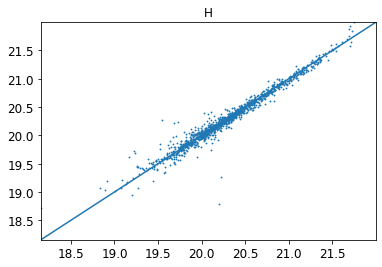

<Figure size 432x288 with 0 Axes>

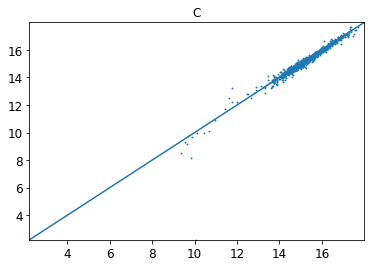

<Figure size 432x288 with 0 Axes>

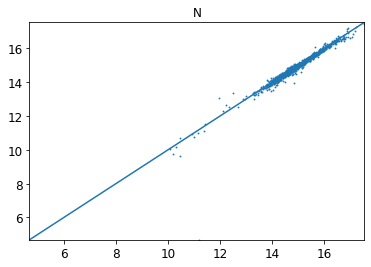

<Figure size 432x288 with 0 Axes>

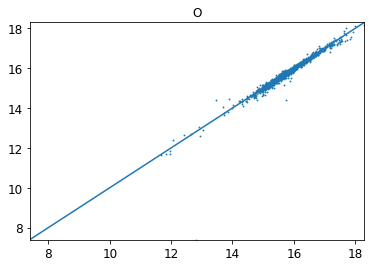

<Figure size 432x288 with 0 Axes>

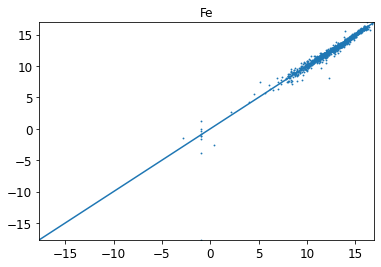

<Figure size 432x288 with 0 Axes>

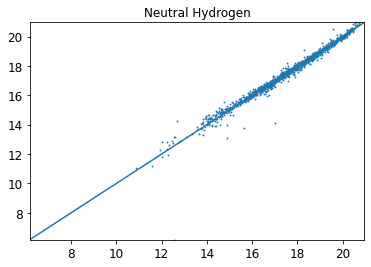

<Figure size 432x288 with 0 Axes>

In [10]:
CDs=['H', 'C', 'N', 'O', 'Fe', 'Neutral Hydrogen']
for i in range(6):
  fig=plt.figure()
  ax=fig.add_subplot(111)
  axis_limits=[min(min(y_val[:, i]), min(ae_nn_test_sc[:, i])), max(max(y_val[:, i]), max(ae_nn_test_sc[:, i]))]
  ax.set_xlim(*axis_limits)
  ax.set_ylim(*axis_limits)
  ax.set_title(CDs[i])
  plt.scatter(y_val[:,i], ae_nn_test_sc[:,i], s=0.7)
  plt.plot(np.linspace(*axis_limits), np.linspace(*axis_limits))
  plt.show()
  plt.clf()